<a href="https://colab.research.google.com/github/yoavdana/ex1_DL/blob/main/ex1_final_practical_part.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [135]:
import torch 
import numpy as np
import scipy.stats as si
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import f1_score
import torch.optim as optim
import torch.utils.data as data
from time import time
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm import tqdm
import pandas as pd

# Data Proccesing

In [136]:
SEQ_LENGTH = 20
BATCH_SIZE = 64
MAPPING = {'A': 0, 'R': 1, 'N': 2, 'D': 3, 'C': 4, 'E': 5, 'Q': 6, 'G': 7, 'H': 8, 'I': 9, 'L': 10, 'K': 11,
              'M': 12, 'F': 13, 'P': 14, 'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19}


def data_to_input(sequence, pos_or_neg):
    map=np.zeros((9, 20))
    for i, seq in enumerate(sequence):
        map[i,MAPPING[seq]]+=1
    map = map.flatten()
    if pos_or_neg==None:
        return map
    return np.concatenate([map, np.array([pos_or_neg])])

def read_data(filename, pos_or_neg):
    file = open(filename, 'r')
    lines=file.readlines()
    data = np.zeros((len(lines), 181))
    if pos_or_neg == None:
        data = np.zeros((len(lines), 180))
    for i, line in enumerate(lines):
        input = data_to_input(line.replace('\n', ''), pos_or_neg)
        data[i] = input
    return data

def bootstrap(data,size,NUMBER_OF_BATCHS):

    N=data.shape[0]
    batch_size=N//NUMBER_OF_BATCHS
    for i in range(NUMBER_OF_BATCHS):
        random = np.random.randint(batch_size*i,batch_size*(i+1), size=size//NUMBER_OF_BATCHS)
        data =np.vstack([DATA,DATA[random, :]])
    return data


def data_pre_pros(filename_pos,filename_neg):

    neg_data=read_data(filename_neg, 0)
    pos_data=read_data(filename_pos, 1)
    np.random.shuffle(neg_data)
    np.random.shuffle(pos_data)

    neg_data_train = neg_data[:int(len(neg_data)*0.9)]
    neg_data_test = neg_data[int(len(neg_data)*0.9):]
    pos_data_train = pos_data[:int(len(pos_data)*0.9)]
    pos_data_test = pos_data[int(len(pos_data)*0.9):]
    #pos_data_train = bootstrap(pos_data_train, int(BOOTSTRAP_SIZE*0.9), int(NUMBER_OF_BATCHS*0.9))
    #pos_data_test = bootstrap(pos_data_test, int(BOOTSTRAP_SIZE*0.1), int(NUMBER_OF_BATCHS*0.1))

    final_data_train = np.concatenate([neg_data_train, pos_data_train])
    final_data_test = np.concatenate([neg_data_test, pos_data_test])
    return final_data_train, final_data_test


def shuffle_data(data_Xy):
    np.random.shuffle(data_Xy)
    return data_Xy[:,:180],data_Xy[:,-1]


def spike_seq(filename):
    with open(filename) as f:
        lines = f.readlines()[0]
        predeict=list()
        sequences = list()

        if len(lines) == 9:
            map = np.zeros((9, 20))
            sequences.append(lines)
            for i, seq in enumerate(lines):
                map[i, MAPPING[seq]] += 1
            map = map.flatten()
            predeict.append(map)
        else:
            for i in range(len(lines)-9):
                map = np.zeros((9, 20))
                sequences.append(lines[i:i+9])
                for i, seq in enumerate(lines[i:i+9]):       
                    map[i, MAPPING[seq]] += 1
                map = map.flatten()
                predeict.append(map)
        
        return np.array(predeict), sequences


# Loading Data

In [137]:
filename_pos='/content/ex1_DL/resorces/pos_A0201.txt'
filename_neg='/content/ex1_DL/resorces/neg_A0201.txt'

train_set, test_set=data_pre_pros(filename_pos,filename_neg)
train_x, train_y = train_set[:,:180], train_set[:,-1]
test_x, test_y = test_set[:,:180], test_set[:,-1]

train_target = torch.from_numpy(train_y.astype(np.int64))
train = torch.from_numpy(train_x.astype(np.float32)) 
train_tensor = torch.utils.data.TensorDataset(train, train_target) 
train_dataloader = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = BATCH_SIZE, shuffle = True)

test_target = torch.from_numpy(test_y.astype(np.int64))
test = torch.from_numpy(test_x.astype(np.float32)) 
test_tensor = torch.utils.data.TensorDataset(test, test_target) 
test_dataloader = torch.utils.data.DataLoader(dataset = test_tensor, batch_size = BATCH_SIZE, shuffle = True)


# Evaluation functions

In [138]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    

def calculate_accuracy(y_true, y_pred, is_training=False):
    if y_pred.ndim == 2:
        y_pred = y_pred.argmax(dim=1)
       
   
    tp = (y_true * y_pred).sum().to(torch.float32)
    tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
    fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
   
    epsilon = 1e-7
   
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    accuracy = (tp + tn) / (tp + tn + fp + fn + epsilon)
   
    f1 = 2* (precision*recall) / (precision + recall + epsilon)
    f1.requires_grad = is_training
    return accuracy

## Network architecture

In [139]:
# Network parameters
INPUT=180
INPUT_1=25
INPUT_2=18
INPUT_3=10
INPUT_4=3
OUTPUT=2
P_DROPOUT=0.28
P_DROPOUT_2=0.15

LEARNNING_RATE=0.0001

BOOTSTRAP_SIZE=15000
NUMBER_OF_BATCHS=150

EPOCHS = 50

In [140]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        self.input_fc = nn.Linear(INPUT, INPUT_1)
        
        self.hidden_1_fc = nn.Linear(INPUT_1, INPUT_2)
        
        self.hidden_2_fc = nn.Linear(INPUT_2, INPUT_3)

        self.hidden_3_fc = nn.Linear(INPUT_3, INPUT_4)

        self.output_fc = nn.Linear(INPUT_4, OUTPUT)

        self.dropout = nn.Dropout(P_DROPOUT)

        
        self.batch_norm_1 = nn.BatchNorm1d(INPUT_1)



    def forward(self, x):
   

        h_1 = F.relu(self.batch_norm_1(self.input_fc(x)))

        h_1=self.dropout(h_1)

        h_2 = F.relu(self.hidden_1_fc(h_1))

        h_3 = F.relu(self.hidden_2_fc(h_2))

        h_4 = F.relu(self.hidden_3_fc(h_3))

        y_pred = self.output_fc(h_4)

        return y_pred, h_4



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Network().to(device)
optimizer=optim.Adam(model.parameters(), lr=LEARNNING_RATE)
weights = [train_set.shape[0]/(2*2.4*np.sum(train_set[:, -1])), 2.6*np.sum(train_set[:, -1])/(2*(train_set.shape[0]-np.sum(train_set[:, -1])))] #as class distribution
weights.reverse()
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train Loop

In [141]:
def train_model(model, train_dataloader, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for i,batch in enumerate(train_dataloader):
        batch=[item.to(device) for item in batch]
        sequences, labels=batch
        # zero the parameter gradients
        optimizer.zero_grad()
      
        # forward 
        outputs, _ = model(sequences)
        #calculate the loss between the target and the actuals
        loss= criterion(input=outputs, target=labels)
        #Gradient calculation uisng backward pass
        acc=calculate_accuracy(labels, outputs)
        loss.backward()
        # update the weights
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(train_dataloader), epoch_acc / len(train_dataloader)


def evaluate(model, test_dataloader, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    for i,batch in enumerate(test_dataloader):
        batch=[item.to(device) for item in batch]
        sequences, labels=batch
        # zero the parameter gradients
        optimizer.zero_grad()
      
        # forward 
        outputs, _ = model(sequences)
        #calculate the loss between the target and the actuals
        loss= criterion(input=outputs, target=labels)
        #Gradient calculation uisng backward pass
        acc=calculate_accuracy(labels, outputs)
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(test_dataloader), epoch_acc / len(test_dataloader)


The model has 5,274 trainable parameters
weights: [0.15871064331730333, 1.9147931376192246]
Epoch: 01
	Train Loss: 0.678 | Train Acc: 10.89%
Epoch: 01
	Test Loss: 0.666 | Test Acc: 10.98%
Epoch: 02
	Train Loss: 0.619 | Train Acc: 43.41%
Epoch: 02
	Test Loss: 0.546 | Test Acc: 71.49%
Epoch: 03
	Train Loss: 0.470 | Train Acc: 76.31%
Epoch: 03
	Test Loss: 0.394 | Test Acc: 78.51%
Epoch: 04
	Train Loss: 0.348 | Train Acc: 79.51%
Epoch: 04
	Test Loss: 0.303 | Test Acc: 80.98%
Epoch: 05
	Train Loss: 0.286 | Train Acc: 82.03%
Epoch: 05
	Test Loss: 0.277 | Test Acc: 82.18%
Epoch: 06
	Train Loss: 0.271 | Train Acc: 83.16%
Epoch: 06
	Test Loss: 0.273 | Test Acc: 82.44%
Epoch: 07
	Train Loss: 0.259 | Train Acc: 83.96%
Epoch: 07
	Test Loss: 0.268 | Test Acc: 84.73%
Epoch: 08
	Train Loss: 0.254 | Train Acc: 84.64%
Epoch: 08
	Test Loss: 0.266 | Test Acc: 84.11%
Epoch: 09
	Train Loss: 0.246 | Train Acc: 84.89%
Epoch: 09
	Test Loss: 0.271 | Test Acc: 85.75%
Epoch: 10
	Train Loss: 0.242 | Train Acc: 85

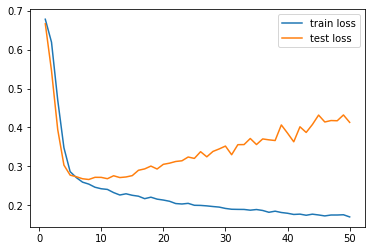

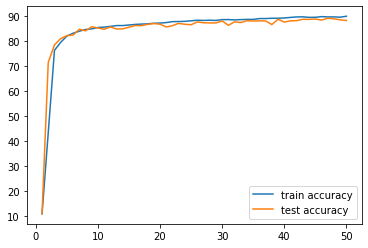

In [142]:
print(f'The model has {count_parameters(model):,} trainable parameters')
print(f'weights: {weights}')
train_per_ep=[]
test_per_ep=[]
train_acc_per_ep = []
test_acc_per_ep =[]
test_acc = 0
for epoch in range(EPOCHS):
    train_loss, train_acc = train_model(model, train_dataloader, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model, test_dataloader,criterion, device)
    
    train_per_ep.append(train_loss)
    test_per_ep.append(test_loss)
    train_acc_per_ep.append(train_acc *100)
    test_acc_per_ep.append(test_acc * 100)
    
    print(f'Epoch: {epoch + 1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
    print(f'Epoch: {epoch + 1:02}')
    print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc * 100:.2f}%')

train_per_ep=np.array(train_per_ep)
test_per_ep=np.array(test_per_ep)
train_acc_per_ep=np.array(train_acc_per_ep)
test_acc_per_ep=np.array(test_acc_per_ep)
epocs=np.arange(1,EPOCHS+1)
print(np.mean(np.abs(np.array(train_per_ep) - np.array(test_per_ep))))
plt.figure()
plt.plot(epocs,train_per_ep)
plt.plot(epocs,test_per_ep)
plt.legend(['train loss','test loss'])
plt.show()

plt.figure()
plt.plot(epocs,train_acc_per_ep)
plt.plot(epocs,test_acc_per_ep)
plt.legend(['train accuracy','test accuracy'])
plt.show()

# Q7

In [143]:
seq, sequences=spike_seq('/content/ex1_DL/resorces/spike_acid.txt')
print('Amount of sequences:', len(seq))
seq = torch.from_numpy(seq.astype('float32'))
seq = seq.to(device)
y_pred, _ = model(seq)
z = y_pred
my_softmax = nn.Softmax(dim=1)
z = my_softmax(z)
top_five = torch.topk(z[:,1], 5)
result = list()
for index in top_five[1]:
    result.append(sequences[index])
print("Top 5 sequences:", list(result))
print("Top 5 sequences probabilities of positive detect:" ,top_five[0].tolist())


Amount of sequences: 1264
Top 5 sequences: ['NLREFVFKN', 'ALLAGTITS', 'PLVDLPIGI', 'LLIVNNATN', 'IPTNFTISV']
Top 5 sequences probabilities of positive detect: [0.9807948470115662, 0.9787039756774902, 0.9686368107795715, 0.968552827835083, 0.964146077632904]


# Q8

In [243]:
def optimize_sequence():
    max_prob = 0
    max_m = 0
    loss_values = list()
    nums = list()
    probs = list()

    for i in range(10):
        loss_values_temp = list()
        nums_temp = list()
        probs_temp = list()

        w1 = torch.randn((1, 9, 20), device=device, requires_grad=True)
        w1 = w1.flatten(1)
        y = torch.ones(1)

        f = model
        f.requires_grad_(False)
        x = nn.Parameter(w1, requires_grad=True)
        optim_sgd = torch.optim.SGD([x], lr=0.002)
        c_entropy = nn.CrossEntropyLoss()
        soft_max = nn.Softmax(dim=1)

        num_steps = 100  # how many optim steps to take
        for _ in range(1, num_steps):            
            loss = c_entropy(f(x)[0], y.type(torch.LongTensor))
            loss.backward()
            loss_values_temp.append(loss)
            t = soft_max(f(x)[0])
            probs_temp.append(t[0][1])
            optim_sgd.step()
            optim_sgd.zero_grad()
            nums_temp.append(_)


        x = nn.Parameter(x, requires_grad=False)    
        x = x.reshape(9,20)
        a = soft_max(x).argmax(1)
        m = torch.zeros (x.shape).scatter (1, a.unsqueeze (1), 1.0)
        if soft_max(f(m.reshape(1, 180))[0])[0].tolist()[1] > max_prob:
            max_prob = soft_max(f(m.reshape(1, 180))[0])[0].tolist()[1]
            max_m = m
            loss_values = loss_values_temp
            probs = probs_temp
            nums = nums_temp

    # mapping
    res = list()    
    for row in max_m:
        ind = torch.where(row == 1)
        res.append((ind[0].tolist()[0]))
    final_res = ''
    for i in res:
        for j,val in enumerate(list(MAPPING.values())):
          if val == i:
            final_res += list(MAPPING.keys())[j]


    plt.figure()
    plt.plot(nums,loss_values)
    plt.legend(['loss values'])
    plt.show()

    plt.figure()
    plt.plot(nums,probs)
    plt.legend(['probebility'])
    plt.show()


    return final_res